# StyleGAN

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from PIL import Image
from datetime import datetime
import copy
import os
import random

## Increasing Variation Using Minibatch Standard Deviation

In [2]:
class MinibatchStdDev(nn.Module):
    def __init__(self, in_channels, group_size=4, epsilon=1e-8):
        super().__init__()

        self.in_channels = in_channels
        self.group_size = group_size
        self.epsilon = epsilon
    
    def forward(self, x):
        assert self.group_size <= x.shape[0]

        B, C, H, W = x.shape
        
        assert B % self.group_size == 0

        y = x.view(self.group_size, -1, C, H, W)              # GMCHW
        y = y - y.mean(dim=0, keepdim=True)                   # GMCHW
        y = torch.sqrt(y.square().mean(dim=0) + self.epsilon) # MCHW
        y = y.mean(dim=[1, 2, 3], keepdim=True)               # M111
        y = y.repeat(self.group_size, 1, H, W)                # B1HW
        y = torch.cat([x, y], dim=1)                          # B(C+1)HW

        return y

MinibatchStdDev(10)(torch.randn(32, 10, 4, 4)).shape

torch.Size([32, 11, 4, 4])

## Equalized Learning Rate

$\^{w} = w_i \times \sqrt{\frac{2}{k \times k \times c}}$

$k \times k \times c = $ filters size

In [3]:
class EqualizedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding)

        nn.init.normal_(self.weight)
        nn.init.zeros_(self.bias)

        self.scale = np.sqrt(2/(kernel_size * kernel_size * in_channels))

    def forward(self, x):
        return torch.conv2d(x, self.weight * self.scale, self.bias, self.stride, self.padding)

EqualizedConv2d(10, 20, 3, 1, 0)(torch.randn(32, 10, 4, 4)).shape

torch.Size([32, 20, 2, 2])

In [4]:
class EqualizedLinear(nn.Linear):
    def __init__(self, in_features, out_features, lr_multiplier=1, bias_init=0.):
        super().__init__(in_features, out_features)

        nn.init.normal_(self.weight, mean=0, std=1./lr_multiplier)
        nn.init.constant_(self.bias, bias_init)

        self.weight_scale = lr_multiplier * np.sqrt(2/in_features)
        self.bias_scale = lr_multiplier
    
    def forward(self, x):
        weight = self.weight * self.weight_scale
        bias = self.bias * self.bias_scale if self.bias_scale != 1 else self.bias
        
        return F.linear(x, weight, bias)

EqualizedLinear(20, 10)(torch.randn(32, 20)).shape

torch.Size([32, 10])

## Pixelwise Feature Vector Normalization In Generator

<img src="architecture_images/pixel_norm.png" width=400>

$b_{x, y} = a_{x, y} / \sqrt{\frac{1}{N} \sum^{N-1}_{j=0} (a_{x, y}^j)^2 + \epsilon}$

In [5]:
class PixelwiseFeatureVectorNormalization(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()

        self.epsilon = epsilon

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)


PixelwiseFeatureVectorNormalization()(torch.randn(32, 10, 4, 4)).shape

torch.Size([32, 10, 4, 4])

## Mapping Network

<img src="architecture_images/mapping_network.png" width=400>

In [6]:
class NoiseMappingNetwork(nn.Module):
    def __init__(self, z_dim, hidden_dim, w_dim, num_layers=8, lr_multiplier=0.01):
        super().__init__()

        assert num_layers >= 2

        self.net = nn.Sequential(
            PixelwiseFeatureVectorNormalization()
        )

        for i in range(num_layers):
            in_features = z_dim if i == 0 else hidden_dim
            out_features = w_dim if i == num_layers-1 else hidden_dim
            self.net.append(EqualizedLinear(in_features, out_features, lr_multiplier=lr_multiplier))
            self.net.append(nn.LeakyReLU(negative_slope=0.2))
    
    def forward(self, z):
        return self.net(z)


NoiseMappingNetwork(512, 512, 512)(torch.randn(64, 512)).shape

torch.Size([64, 512])

## Stochastic variation

<img src="architecture_images/stochastic_variation.png" width=400>

In [7]:
class RandomNoiseInjection(nn.Module):
    def __init__(self, num_channels):
        super().__init__()

        self.weight = nn.Parameter(torch.randn(1, num_channels, 1, 1))

        self._is_turned_off = False
    
    def turn_off(self):
        self._is_turned_off = True
    
    def turn_on(self):
        self._is_turned_off = False
    
    def forward(self, image):
        if self._is_turned_off:
            return image
        
        noise = torch.randn((image.size(0), 1, image.size(2), image.size(3))).to(image.device)

        return image + self.weight * noise


RandomNoiseInjection(512)(torch.randn(64, 512, 4, 4)).shape

torch.Size([64, 512, 4, 4])

## Adaptive Instance Normalization

<img src="architecture_images/adain.png" width=400>

In [8]:
class AdaIN(nn.Module):
    def __init__(self, w_dim, num_channels):
        super().__init__()

        self.instance_norm = nn.InstanceNorm2d(num_channels)

        self.style_scale_transform = EqualizedLinear(w_dim, num_channels, bias_init=1.)
        self.style_shift_transform = EqualizedLinear(w_dim, num_channels)
    
    def forward(self, image, w):
        style_scale = self.style_scale_transform(w)[:, :, None, None]
        style_shift = self.style_shift_transform(w)[:, :, None, None]

        return  style_scale * self.instance_norm(image) + style_shift


AdaIN(512, 128)(torch.randn(64, 128, 4, 4), torch.randn(64, 512)).shape

torch.Size([64, 128, 4, 4])

## Up/Down Sampling

In [9]:
BLUR_FILTER = torch.tensor([
    [0.0625, 0.125 , 0.0625],
    [0.125 , 0.25  , 0.125 ],
    [0.0625, 0.125 , 0.0625]
])[None, None, :, :]

class Blur(nn.Module):
    def __init__(self, filter=BLUR_FILTER):
        super().__init__()

        self.filter = nn.Parameter(filter, requires_grad=False)
    
    def forward(self, x):
        x = nn.functional.conv2d(
            x,
            weight=self.filter.expand(x.shape[1], -1, -1, -1),
            bias=None,
            padding='same',
            groups=x.shape[1]
        )

        return x

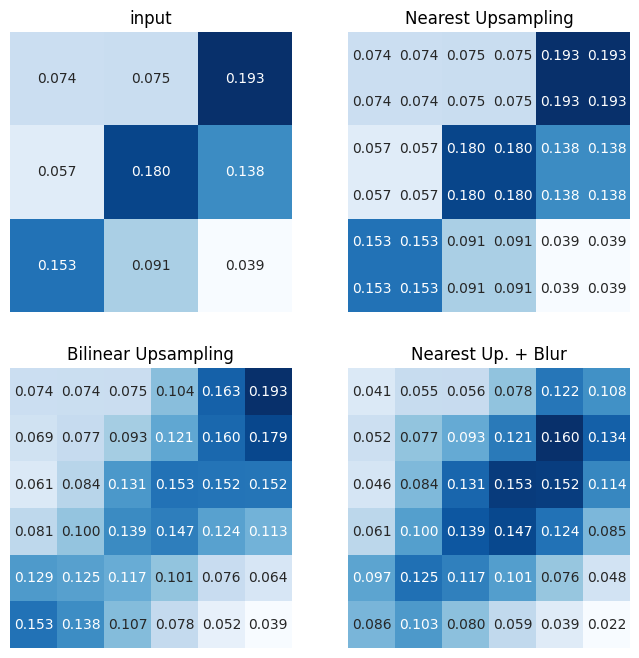

In [10]:
import seaborn as sns

# x = torch.arange(9).reshape(1, 1, 3, 3)/9
x = torch.rand((9, )).reshape(1, 1, 3, 3)
x = x / x.sum()

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].set_title("input")
sns.heatmap(x[0, 0], ax=axs[0, 0], cbar=False, annot=True, xticklabels=False, yticklabels=False, fmt='.3f', cmap='Blues')

axs[0, 1].set_title("Nearest Upsampling")
x_new = nn.Upsample(scale_factor=2)(x)
sns.heatmap(x_new[0, 0], ax=axs[0, 1], cbar=False, annot=True, xticklabels=False, yticklabels=False, fmt='.3f', cmap='Blues')

axs[1, 0].set_title("Bilinear Upsampling")
x_new2 = nn.Upsample(scale_factor=2, mode='bilinear')(x)
sns.heatmap(x_new2[0, 0], ax=axs[1, 0], cbar=False, annot=True, xticklabels=False, yticklabels=False, fmt='.3f', cmap='Blues')

axs[1, 1].set_title("Nearest Up. + Blur")
x_new3 = Blur()(nn.Upsample(scale_factor=2)(x))
sns.heatmap(x_new3[0, 0], ax=axs[1, 1], cbar=False, annot=True, xticklabels=False, yticklabels=False, fmt='.3f', cmap='Blues')

plt.show();

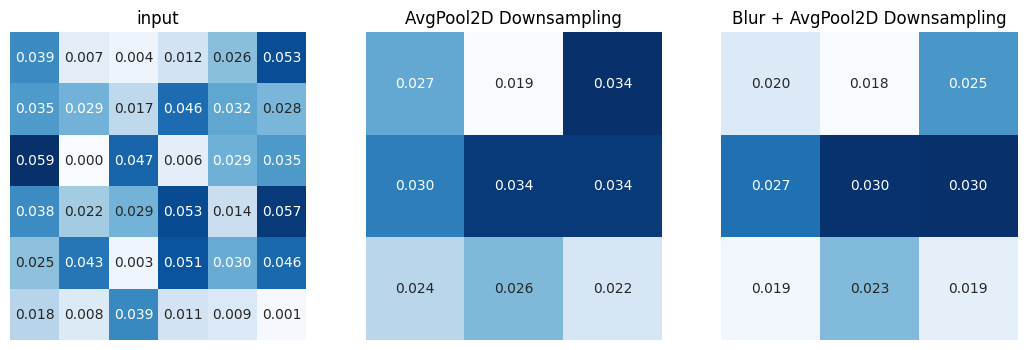

In [11]:
import seaborn as sns

x = torch.rand((36, )).reshape(1, 1, 6, 6)
x = x / x.sum()

fig, axs = plt.subplots(1, 3, figsize=(13, 4))

axs[0].set_title("input")
sns.heatmap(x[0, 0], ax=axs[0], cbar=False, annot=True, xticklabels=False, yticklabels=False, fmt='.3f', cmap='Blues')

axs[1].set_title("AvgPool2D Downsampling")
x_new = nn.AvgPool2d(2)(x)
sns.heatmap(x_new[0, 0], ax=axs[1], cbar=False, annot=True, xticklabels=False, yticklabels=False, fmt='.3f', cmap='Blues')

axs[2].set_title("Blur + AvgPool2D Downsampling")
x_new2 = nn.AvgPool2d(2)(Blur()(x))
sns.heatmap(x_new2[0, 0], ax=axs[2], cbar=False, annot=True, xticklabels=False, yticklabels=False, fmt='.3f', cmap='Blues')

plt.show();

**[Note]** in the StyleGAN implementation, they have used *Blur* layers before downsampling (down_conv) and after upsampling (up_conv). However, we won't do this in this implementation. We just simply use `AvgPool2d` and `Upsample(mode='bilinear')`.

## Truncation Trick

In [12]:
class TruncationSampling(nn.Module):
    def __init__(self, w_avg, psi=0.7, beta=0.995):
        super().__init__()

        self.psi = psi
        self.beta = beta

        self.register_buffer('w_avg', w_avg)
    
    def update(self, w_avg_new):
        self.w_avg.copy_(self.beta * self.w_avg + (1. - self.beta) * w_avg_new)
    
    def forward(self, w):
        return torch.lerp(self.w_avg, w, self.psi)
    

truncation_sampling = TruncationSampling(w_avg=torch.zeros(512, dtype=torch.float))

print(truncation_sampling.w_avg.mean())
print(truncation_sampling(torch.ones(512, dtype=torch.float) * 10).mean())

truncation_sampling.update(w_avg_new=torch.ones(512) * 1000.)

print(truncation_sampling.w_avg.mean())
print(truncation_sampling(torch.ones(512, dtype=torch.float) * 10).mean())

tensor(0.)
tensor(7.)
tensor(5.)
tensor(8.5000)


## Generator

<img src="architecture_images/generator_init_block.png" width=400>

In [13]:
class GeneratorInitialBlock(nn.Module):
    def __init__(self, out_channels, w_dim):
        super().__init__()

        self.starting_constant = nn.Parameter(torch.ones((1, out_channels, 4, 4)))
        self.constant_bias = nn.Parameter(torch.ones(out_channels))

        self.net1 = nn.Sequential(
            RandomNoiseInjection(out_channels),
            nn.LeakyReLU(negative_slope=0.2)
        )
        self.adain1 = AdaIN(w_dim, out_channels)

        self.conv = EqualizedConv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

        self.net2 = nn.Sequential(
            RandomNoiseInjection(out_channels),
            nn.LeakyReLU(negative_slope=0.2),
        )
        self.adain2 = AdaIN(w_dim, out_channels)

    def forward(self, w):
        out = self.starting_constant.expand(w.shape[0], -1, -1, -1) + self.constant_bias.view(1, -1, 1, 1)
        
        out = self.net1(out)
        out = self.adain1(out, w)

        out = self.conv(out)

        out = self.net2(out)
        out = self.adain2(out, w)

        return out


GeneratorInitialBlock(512, 256)(torch.randn(4, 256)).shape

torch.Size([4, 512, 4, 4])

<img src="architecture_images/generator_block.png" width=400>

In [14]:
class GeneratorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, w_dim):
        super().__init__()

        self.net1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            EqualizedConv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            RandomNoiseInjection(out_channels),
            nn.LeakyReLU(negative_slope=0.2),
        )
        self.adain1 = AdaIN(w_dim, out_channels)
        self.net2 = nn.Sequential(
            EqualizedConv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            RandomNoiseInjection(out_channels),
            nn.LeakyReLU(negative_slope=0.2),
        )
        self.adain2 = AdaIN(w_dim, out_channels)

    def forward(self, x, w):
        out = self.net1(x)
        out = self.adain1(out, w)
        out = self.net2(out)
        out = self.adain2(out, w)

        return out


GeneratorBlock(in_channels=64, out_channels=32, w_dim=512)(torch.randn(10, 64, 256, 256), torch.randn(10, 512)).shape

torch.Size([10, 32, 512, 512])

In [15]:
def is_power_of_two(num):
    return (num & (num - 1)) == 0 and num != 0

def get_num_of_steps_from_image_size(image_size):
    return int(np.log2(image_size) - 1)

In [16]:
class GeneratorSynthesis(nn.Module):
    def __init__(self, w_dim=512, image_size=1024, image_channels=3, steps_out_channels=[512, 512, 512, 256, 128, 64, 32, 16]):
        super().__init__()
        
        assert is_power_of_two(image_size)
        self.num_steps = get_num_of_steps_from_image_size(image_size)

        assert len(steps_out_channels) == self.num_steps - 1

        self.net = nn.ModuleList([GeneratorInitialBlock(w_dim, w_dim)])

        steps_in_channels = [w_dim] + steps_out_channels[:-1]
        for in_channels, out_channels in zip(steps_in_channels, steps_out_channels):
            self.net.append(GeneratorBlock(in_channels, out_channels, w_dim))

        self.to_rgb = nn.ModuleList([
            EqualizedConv2d(channels, image_channels, kernel_size=1, stride=1, padding=0) for channels in [w_dim] + steps_out_channels
        ])

        self.img_upsampler = nn.Upsample(scale_factor=2)

    def forward(self, w, step: int, alpha: float):
        assert alpha >= 0 and alpha <= 1
        assert step >= 1 and step < self.num_steps
        assert w.ndim == 3 and w.shape[1] == step+1 # B, step+1, w_dim

        prev_step_output = self.net[0](w[:, 0])

        if step == 1:
            return self.to_rgb[1](self.net[1](prev_step_output, w[:, 1]))
        
        for i in range(1, step):
            prev_step_output = self.net[i](prev_step_output, w[:, i])
            
        prev_step_rgb = self.to_rgb[step-1](prev_step_output)
        prev_step_rgb_upsampled = self.img_upsampler(prev_step_rgb)
        
        step_output = self.net[step](prev_step_output, w[:, step])
        step_rgb = self.to_rgb[step](step_output)

        final_rgb = alpha * step_rgb + (1 - alpha) * prev_step_rgb_upsampled

        return final_rgb


# print(Generator()(z=torch.randn(2, 512), step=0, alpha=0).shape)
print(GeneratorSynthesis()(w=torch.randn(2, 2, 512), step=1, alpha=0).shape)
print(GeneratorSynthesis()(w=torch.randn(2, 6, 512), step=5, alpha=0).shape)
print(GeneratorSynthesis()(w=torch.randn(2, 7, 512), step=6, alpha=0).shape)
print(GeneratorSynthesis()(w=torch.randn(2, 9, 512), step=8, alpha=0).shape)

torch.Size([2, 3, 8, 8])
torch.Size([2, 3, 128, 128])
torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 1024, 1024])


In [17]:
class Generator(nn.Module):
    def __init__(
            self,
            z_dim=512,
            w_dim=512,
            image_size=1024,
            image_channels=3,
            steps_out_channels=[512, 512, 512, 256, 128, 64, 32, 16],
            style_mixing_prob=0.9
        ):
        super().__init__()
        
        self.generator_synthesis = GeneratorSynthesis(w_dim, image_size, image_channels, steps_out_channels)
        self.noise_mapping = NoiseMappingNetwork(z_dim, w_dim, w_dim)
        self.truncation_sampling = TruncationSampling(w_avg=torch.zeros(w_dim))

        self.style_mixing_prob = style_mixing_prob
    
    def switch_noise_injection_on(self):
        self._switch_noise_injection_on_off(self, on_or_off="on")

    def switch_noise_injection_off(self):
        self._switch_noise_injection_on_off(self, on_or_off="off")
    
    def _switch_noise_injection_on_off(self, model, on_or_off):
        assert on_or_off in ["on", "off"]

        for _, module in model.named_children():
            if isinstance(module, nn.Module):
                if isinstance(module, RandomNoiseInjection):
                    if on_or_off == "on":
                        module.turn_on()
                    elif on_or_off == "off":
                        module.turn_off()
                    else:
                        raise Exception("on_or_off is neither 'on' or 'off'!")

                self._switch_noise_injection_on_off(module, on_or_off)
    

    def forward(self, z, step: int, alpha: float):
        assert step >= 1
        assert z.ndim == 2 # B, z_dim

        # Noise Mapping (Z -> W)
        w = self.noise_mapping(z).unsqueeze(1).expand(-1, step+1, -1)

        # Apply Style Mixing Regularizer
        if self.training:
            z2 = torch.randn_like(z)
            w2 = self.noise_mapping(z2).unsqueeze(1).expand(-1, step+1, -1)

            layer_indices = torch.arange(step+1)[None, :, None].to(z.device)

            if random.random() < self.style_mixing_prob:
                mixin_cutoff = random.randint(1, step+1)
            else:
                mixin_cutoff = torch.inf

            w = torch.where(layer_indices < mixin_cutoff, w, w2)

        # Truncation Trick
        if self.training:
            self.truncation_sampling.update(w_avg_new=w[:, 0, :].detach().mean(axis=0))
        
        w = self.truncation_sampling(w) # TODO: I don't think this is something they do during training. Remove this and use it after the model is fully trained
        
        return self.generator_synthesis(w, step, alpha)


# print(Generator()(z=torch.randn(2, 512), step=0, alpha=0).shape)
# print(Generator()(z=torch.randn(2, 512), step=1, alpha=0).shape)
print(Generator(z_dim=128, w_dim=256)(z=torch.randn(2, 128), step=5, alpha=0).shape)
print(Generator(z_dim=128, w_dim=256)(z=torch.randn(2, 128), step=6, alpha=0).shape)
print(Generator(z_dim=128, w_dim=256)(z=torch.randn(2, 128), step=8, alpha=0).shape)

torch.Size([2, 3, 128, 128])
torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 1024, 1024])


#### Checking noise injection on/off switch

In [18]:
step, alpha = 5, 1
gen = Generator(z_dim=512, w_dim=512, image_size=256, image_channels=3, steps_out_channels=[512, 512, 512, 256, 128, 64])

z = torch.randn(4, 512)
w = gen.noise_mapping(z).unsqueeze(1).expand(-1, step+1, -1)
w = gen.truncation_sampling(w)

imgs1 = gen.generator_synthesis(w, step=step, alpha=alpha)
imgs2 = gen.generator_synthesis(w, step=step, alpha=alpha)
print("Are generated image from the same W equal?", torch.all(imgs1 == imgs2).item(), "\n------------------")

gen.switch_noise_injection_off()
imgs1 = gen.generator_synthesis(w, step=step, alpha=alpha)
imgs2 = gen.generator_synthesis(w, step=step, alpha=alpha)
print("Are generated image from the same W equal?", torch.all(imgs1 == imgs2).item(), "\n------------------")

gen.switch_noise_injection_on()
imgs1 = gen.generator_synthesis(w, step=step, alpha=alpha)
imgs2 = gen.generator_synthesis(w, step=step, alpha=alpha)
print("Are generated image from the same W equal?", torch.all(imgs1 == imgs2).item())


Are generated image from the same W equal? False 
------------------
Are generated image from the same W equal? True 
------------------
Are generated image from the same W equal? False


## Discriminator

Same as ProGAN, but it starts from $step=1$ rather than $0$ (i.e. $8\times8$ instead of $4\times4$)

In [19]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.net = nn.Sequential(
            EqualizedConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            EqualizedConv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.AvgPool2d(2),
        )

    def forward(self, x):
        return self.net(x)


DiscriminatorBlock(in_channels=32, out_channels=64)(torch.randn(1, 32, 512, 512)).shape

torch.Size([1, 64, 256, 256])

In [20]:
class DiscriminatorFinalBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.net = nn.Sequential(
            MinibatchStdDev(in_channels=in_channels),
            EqualizedConv2d(in_channels+1, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            EqualizedConv2d(in_channels, in_channels, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            EqualizedLinear(in_channels, 1)
        )
    
    def forward(self, x):
        return self.net(x).squeeze(1)


DiscriminatorFinalBlock(in_channels=512)(torch.randn(4, 512, 4, 4)).shape

torch.Size([4])

In [21]:
class Discriminator(nn.Module):
    def __init__(self, image_size=1024, image_channels=3, steps_in_channels=[16, 32, 64, 128, 256, 512, 512, 512, 512]):
        super().__init__()
        
        self.image_size = image_size
        
        assert is_power_of_two(image_size)
        self.num_steps = get_num_of_steps_from_image_size(image_size)

        assert len(steps_in_channels) == self.num_steps

        self.net = nn.ModuleList([
            DiscriminatorBlock(in_channels, out_channels) for in_channels, out_channels in zip(steps_in_channels[:-1], steps_in_channels[1:])
        ])
        self.net.append(DiscriminatorFinalBlock(steps_in_channels[-1]))

        self.from_rgb = nn.ModuleList([
            nn.Sequential(
                EqualizedConv2d(image_channels, in_channels, kernel_size=1, stride=1, padding=0),
                nn.LeakyReLU(negative_slope=0.2)
            ) for in_channels in steps_in_channels
        ])

        self.img_downsampler = nn.AvgPool2d(2)

    def forward(self, image, step: int, alpha: float):
        assert alpha >= 0 and alpha <= 1
        assert step >= 1 and step < self.num_steps

        first_layer_idx = self.num_steps - step - 1

        assert image.shape[2] == self.image_size>>first_layer_idx

        first_layer_output = self.net[first_layer_idx](self.from_rgb[first_layer_idx](image))

        if step == 1:
            return self.net[-1](first_layer_output)

        second_layer_from_rgb = self.from_rgb[first_layer_idx+1](self.img_downsampler(image))
        x = alpha * first_layer_output + (1 - alpha) * second_layer_from_rgb 
        for i in range(first_layer_idx+1, self.num_steps):
            x = self.net[i](x)
        
        return x

    
# print(Discriminator()(image=torch.randn(4, 3, 4, 4), step=0, alpha=0).shape)
print(Discriminator()(image=torch.randn(4, 3, 16, 16), step=2, alpha=0).shape)
print(Discriminator()(image=torch.randn(4, 3, 256, 256), step=6, alpha=0).shape)
print(Discriminator()(image=torch.randn(4, 3, 1024, 1024), step=8, alpha=0).shape)
print("------------------")
print(Discriminator(image_size=256, steps_in_channels=[64, 128, 256, 512, 512, 512, 512])(image=torch.randn(4, 3, 256, 256), step=6, alpha=0).shape)

torch.Size([4])
torch.Size([4])
torch.Size([4])
------------------
torch.Size([4])


## Exponential Moving Average

In [22]:
def update_exponential_moving_average_generator(ema_gen, gen, decay=0.999):
    gen_named_parameters = dict(gen.named_parameters())
    with torch.no_grad():
        for param_name, param in ema_gen.named_parameters():
            param.copy_(param * decay + (1. - decay) * gen_named_parameters[param_name])

## Training

In [23]:
def show_images(images, title=None):
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid((images + 1) / 2).permute(1, 2, 0))
    if title is not None:
        plt.title(title)
    plt.show()

based on the paper:

 "... for CELEBA-HQ we rely on WGAN-GP ..."

In [24]:
def calc_gradient_penalty(critic, real_images, fake_images, step, alpha, device):
    eps = torch.rand((real_images.size(0), *(1 for _ in range(len(real_images.shape) - 1)))).to(device)
    intermediate_images = eps * real_images + (1 - eps) * fake_images
    intermediate_images.requires_grad_()
    scores = critic(intermediate_images, step, alpha)
    gradients = torch.autograd.grad(outputs=scores, inputs=intermediate_images, grad_outputs=torch.ones_like(scores), create_graph=True, retain_graph=True)[0]
    gradients_norm = torch.norm(gradients.view(gradients.shape[0], -1), dim=1)
    gp = torch.mean((gradients_norm - 1) ** 2)

    return gp

In [25]:
class AdjustPixelsRange(object):
    def __init__(self, range_in, range_out):
        self._range_in = torch.tensor(range_in, dtype=torch.float32)
        self._range_out = torch.tensor(range_out, dtype=torch.float32)

        if range_in == range_out:
            self.scale = 1
            self.bias = 0
        else:
            self.scale = (self._range_out[1] - self._range_out[0]) / (self._range_in[1] - self._range_in[0])
            self.bias = self._range_out[0] - self.scale * self._range_in[0]
    
    def __call__(self, x):
        return torch.clamp(self.scale * x + self.bias, min=self._range_out[0], max=self._range_out[1])

a = np.random.uniform(10, 25, 5)
print(a)
print(AdjustPixelsRange((10, 20), (0, 1))(a).tolist())

[18.94225686 23.77077596 20.78708284 10.32627093 10.80779042]
[0.8942257142878851, 1.0, 1.0, 0.03262710838893179, 0.08077905767376214]


In [26]:
def generate_fixed_noise(size, seed):
    current_seed = torch.initial_seed()
    torch.manual_seed(seed)
    fixed_noise = torch.randn(size)
    torch.manual_seed(current_seed)
    
    return fixed_noise


print(torch.initial_seed())
fixed_noise1 = generate_fixed_noise((36, 100, 1, 1), seed=0)
fixed_noise2 = generate_fixed_noise((36, 100, 1, 1), seed=0)
fixed_noise3 = generate_fixed_noise((36, 100, 1, 1), seed=1)
print(torch.initial_seed())

torch.all(fixed_noise1 == fixed_noise2), torch.all(fixed_noise1 == fixed_noise3)

1315934576548000
1315934576548000


(tensor(True), tensor(False))

In [27]:
def generate_images_and_save(gen: Generator, step: int, epoch: int, alpha: float, fixed_noise: torch.Tensor, path: str):
    
    os.makedirs(path, exist_ok=True)

    with torch.no_grad():
        imgs = gen(fixed_noise, step, alpha).detach().cpu()
        imgs = torchvision.utils.make_grid(AdjustPixelsRange((-1., 1.), (0., 1.))(imgs), nrow=6)
        imgs = transforms.Resize(1500)(imgs).permute(1, 2, 0).numpy()
    
    filename = f"Step {step} - Epoch {epoch} - Alpha {alpha:.8f}.png"
    
    plt.imsave(os.path.join(path, filename), imgs)

In [28]:
def save_models_and_state(
    gen: Generator,
    ema_gen: Generator,
    crit: Discriminator,
    opt_gen: torch.optim.Adam,
    opt_crit: torch.optim.Adam,
    state: dict,
    path: str
):
    os.makedirs(path, exist_ok=True)
    
    torch.save(gen.state_dict(), os.path.join(path, 'gen.pth'))
    torch.save(ema_gen.state_dict(), os.path.join(path, 'ema_gen.pth'))
    torch.save(crit.state_dict(), os.path.join(path, 'crit.pth'))
    torch.save(opt_gen.state_dict(), os.path.join(path, 'opt_gen.pth'))
    torch.save(opt_crit.state_dict(), os.path.join(path, 'opt_crit.pth'))
    torch.save(state, os.path.join(path, 'state.pth'))

### Training on MNIST $(32 \times 32)$

In [39]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])
dataset = torchvision.datasets.MNIST('../../data/mnist', train=True, transform=transform, download=False)

In [44]:
Z_DIM = 128
BATCH_SIZE = 32
NUM_EPOCHS_PER_STEP = 20
NUM_CRITIC_UPDATE = 1
GP_LAMBDA = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


In [45]:
gen = Generator(z_dim=Z_DIM, w_dim=128, image_size=32, image_channels=1, steps_out_channels=[64, 32, 16]).to(device)
crit = Discriminator(image_size=32, image_channels=1, steps_in_channels=[16, 32, 64, 128]).to(device)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

opt_gen = torch.optim.Adam(gen.parameters(), lr=0.001, betas=(0., 0.99), eps=1e-8)
opt_crit = torch.optim.Adam(crit.parameters(), lr=0.001, betas=(0., 0.99), eps=1e-8)

In [46]:
alpha_step = 1 / ((NUM_EPOCHS_PER_STEP // 2) * len(dataset))
step_image_sizes = [4, 8, 16, 32]

In [47]:
fixed_noise = torch.randn(64, Z_DIM).to(device)
images = []
transf = transforms.Compose([transforms.ToPILImage(), transforms.Lambda(lambda x: np.array(x)[:, :, 0])])

for step in range(1, 4):
    alpha = 0
    image_resizer = transforms.Resize(step_image_sizes[step])

    for epoch in range(NUM_EPOCHS_PER_STEP):
        gen.train()
        for real_images, _ in dataloader:
            real_images = image_resizer(real_images).to(device)

            #----- Updating the Discriminator -----#
            for _ in range(NUM_CRITIC_UPDATE):
                noise = torch.randn(real_images.shape[0], Z_DIM).to(device)
                fake_images = gen(noise, step, alpha).detach()
                pred_real, pred_fake = crit(real_images, step, alpha), crit(fake_images, step, alpha)
                loss = -torch.mean(pred_real) + torch.mean(pred_fake) + GP_LAMBDA*calc_gradient_penalty(crit, real_images, fake_images, step, alpha, device)
                crit.zero_grad()
                loss.backward(retain_graph=True)
                opt_crit.step()

            #----- Updating the Generator -----#
            noise = torch.randn(BATCH_SIZE, Z_DIM).to(device)
            loss = -torch.mean(crit(gen(noise, step, alpha), step, alpha))
            gen.zero_grad()
            loss.backward()
            opt_gen.step()

            alpha = min(1, alpha + alpha_step * real_images.size(0))

        gen.eval()
        # clear_output()
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Step {step} - Alpha {alpha:.2f} - Epoch {epoch}")
        imgs = gen(fixed_noise, step, alpha).detach().cpu()
        imgs = torchvision.utils.make_grid((imgs + 1) / 2)
        imgs = transforms.Resize(600)(imgs).permute(1, 2, 0).clip(0, 1).numpy()
        plt.imsave(f"results_mnist/Step {step} - Alpha {alpha:.2f} - Epoch {epoch}.png", imgs)

[2023-07-12 16:44:35] Step 1 - Alpha 0.10 - Epoch 0
[2023-07-12 16:45:47] Step 1 - Alpha 0.20 - Epoch 1
[2023-07-12 16:46:59] Step 1 - Alpha 0.30 - Epoch 2
[2023-07-12 16:48:16] Step 1 - Alpha 0.40 - Epoch 3
[2023-07-12 16:49:27] Step 1 - Alpha 0.50 - Epoch 4
[2023-07-12 16:50:42] Step 1 - Alpha 0.60 - Epoch 5
[2023-07-12 16:52:05] Step 1 - Alpha 0.70 - Epoch 6
[2023-07-12 16:53:21] Step 1 - Alpha 0.80 - Epoch 7
[2023-07-12 16:54:35] Step 1 - Alpha 0.90 - Epoch 8
[2023-07-12 16:55:56] Step 1 - Alpha 1.00 - Epoch 9
[2023-07-12 16:57:10] Step 1 - Alpha 1.00 - Epoch 10
[2023-07-12 16:58:22] Step 1 - Alpha 1.00 - Epoch 11
[2023-07-12 16:59:30] Step 1 - Alpha 1.00 - Epoch 12
[2023-07-12 17:00:42] Step 1 - Alpha 1.00 - Epoch 13
[2023-07-12 17:01:53] Step 1 - Alpha 1.00 - Epoch 14
[2023-07-12 17:03:05] Step 1 - Alpha 1.00 - Epoch 15
[2023-07-12 17:04:10] Step 1 - Alpha 1.00 - Epoch 16
[2023-07-12 17:05:18] Step 1 - Alpha 1.00 - Epoch 17
[2023-07-12 17:06:27] Step 1 - Alpha 1.00 - Epoch 18
[20

In [127]:
# torch.save(gen.state_dict(), 'results_mnist/gen.pth')
# torch.save(crit.state_dict(), 'results_mnist/crit.pth')

gen.load_state_dict(torch.load('results_mnist/gen.pth'))
crit.load_state_dict(torch.load('results_mnist/crit.pth'))

<All keys matched successfully>

In [128]:
gen.eval();

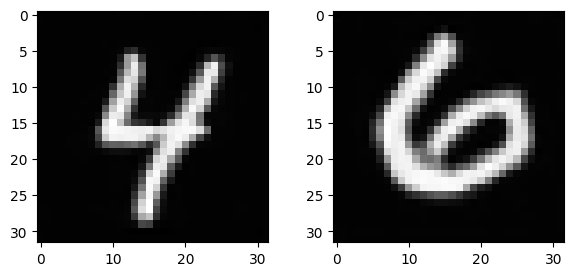

In [133]:
noise = torch.randn(2, Z_DIM).to(device)
images = gen(noise, step=3, alpha=1).detach().cpu().permute(0, 2, 3, 1)

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
axs[0].imshow(images[0], cmap="gray")
axs[1].imshow(images[1], cmap="gray");

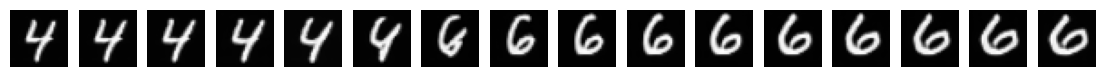

In [134]:
intermediate_noise = gen.noise_mapping(noise)
intermediate_noise = gen.truncation_sampling(intermediate_noise)

cnt = 15
step = (intermediate_noise[1] - intermediate_noise[0]) / cnt
interpolated_noises = []
for i in range(cnt+1):
    interpolated_noises.append(intermediate_noise[0] + step * i)
interpolated_w = torch.stack(interpolated_noises).unsqueeze(1).expand(-1, 4, -1)
interpolated_images = gen.generator_synthesis(w=interpolated_w, step=3, alpha=1).detach().cpu().permute(0, 2, 3, 1)

fig, axs = plt.subplots(1, cnt+1, figsize=(14, 2))
for i in range(cnt+1):
    axs[i].axis("off")
    axs[i].imshow(interpolated_images[i], cmap="gray")

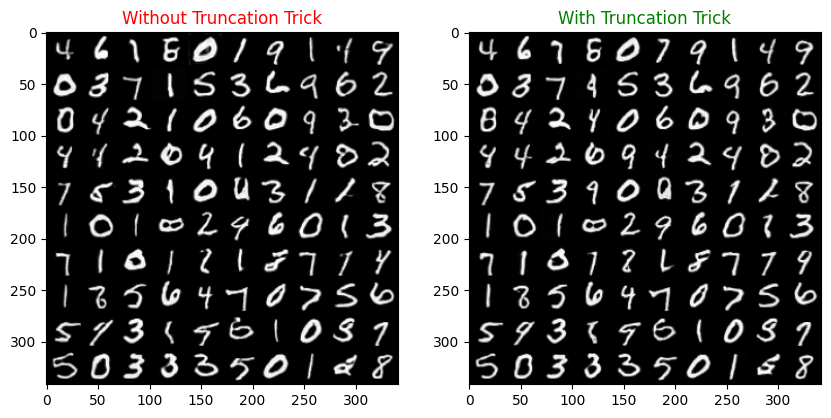

In [136]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

noise = torch.randn(100, Z_DIM).to(device)
w = gen.noise_mapping(noise).unsqueeze(1).expand(-1, 4, -1)
imgs = gen.generator_synthesis(w, step=3, alpha=1).detach().cpu()
imgs = torchvision.utils.make_grid((imgs + 1) / 2, nrow=10)
imgs = imgs.permute(1, 2, 0).clip(0, 1).numpy()

axs[0].set_title("Without Truncation Trick", c='red')
axs[0].imshow(imgs);

w = gen.noise_mapping(noise)
w = gen.truncation_sampling(w).unsqueeze(1).expand(-1, 4, -1)
imgs = gen.generator_synthesis(w=w, step=3, alpha=1).detach().cpu()
imgs = torchvision.utils.make_grid((imgs + 1) / 2, nrow=10)
imgs = imgs.permute(1, 2, 0).clip(0, 1).numpy()

axs[1].set_title("With Truncation Trick", c='green')
axs[1].imshow(imgs);

### Training on CelebA-HQ $(128 \times 128)$

In [29]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    AdjustPixelsRange(range_in=(0., 1.), range_out=(-1., 1.))
])

dataset = torchvision.datasets.ImageFolder(root='../../data/celeba_hq', transform=transform)

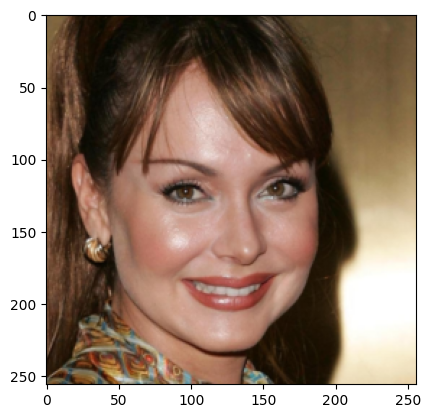

In [30]:
plt.imshow(AdjustPixelsRange((-1., 1.), (0., 1.))(dataset[1][0].permute(1, 2, 0)));

In [31]:
def process_batch_images(images, size: int, prev_size: int, alpha: float, current_size=256):
    assert is_power_of_two(size)
    assert prev_size is None or (is_power_of_two(prev_size) and prev_size == size >> 1)

    step_images = nn.AvgPool2d(current_size//size)(images)

    if prev_size is None:
        return step_images
    
    prev_step_images = nn.AvgPool2d(current_size//prev_size)(images)
    upsampled_prev_step_images = nn.Upsample(scale_factor=2)(prev_step_images)

    return alpha * step_images + (1 - alpha) * upsampled_prev_step_images


process_batch_images(torch.randn(16, 3, 256, 256), 8, 4, 0.7).shape

torch.Size([16, 3, 8, 8])

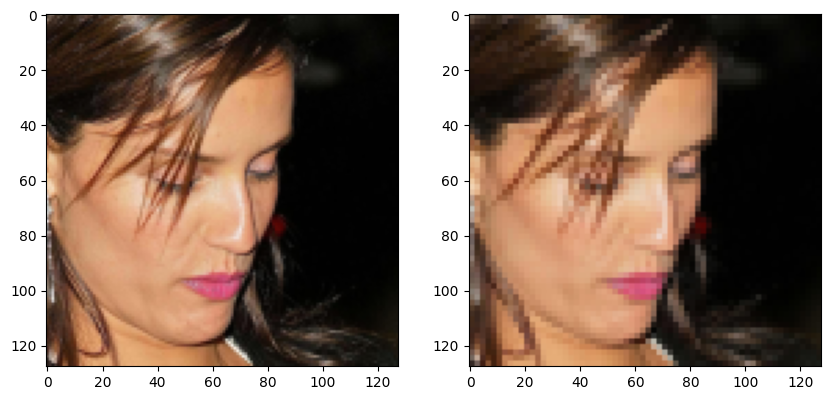

In [32]:
_, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(AdjustPixelsRange((-1, 1), (0, 1))(process_batch_images(dataset[0][0].unsqueeze(0), 128, 64, 1)[0].permute(1, 2, 0)));
axs[1].imshow(AdjustPixelsRange((-1, 1), (0, 1))(process_batch_images(dataset[0][0].unsqueeze(0), 128, 64, 0)[0].permute(1, 2, 0)));

In [33]:
Z_DIM = 512
BATCH_SIZES = [16, 16, 16, 16, 16, 12, 12]
NUM_EPOCHS_PER_STEP = 50
NUM_CRITIC_UPDATE = 1
GP_LAMBDA = 10
DRIFT_LAMBDA = 0.001
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


In [34]:
gen = Generator(z_dim=Z_DIM, w_dim=512, image_size=256, image_channels=3, steps_out_channels=[512, 512, 512, 256, 128, 64]).to(device)
ema_gen = copy.deepcopy(gen)
crit = Discriminator(image_size=256, image_channels=3, steps_in_channels=[64, 128, 256, 512, 512, 512, 512]).to(device)

opt_gen = torch.optim.Adam(gen.parameters(), lr=0.001, betas=(0., 0.99), eps=1e-8)
opt_crit = torch.optim.Adam(crit.parameters(), lr=0.001, betas=(0., 0.99), eps=1e-8)

In [35]:
from_checkpoint = True

if from_checkpoint:
    state_root = 'results_celebahq/step-5 (more epochs)/'

    gen.load_state_dict(torch.load(os.path.join(state_root, 'gen.pth')))
    ema_gen.load_state_dict(torch.load(os.path.join(state_root, 'ema_gen.pth')))
    crit.load_state_dict(torch.load(os.path.join(state_root, 'crit.pth')))
    opt_gen.load_state_dict(torch.load(os.path.join(state_root, 'opt_gen.pth')))
    opt_crit.load_state_dict(torch.load(os.path.join(state_root, 'opt_crit.pth')))

    state = torch.load(os.path.join(state_root, 'state.pth'))
else:
    state = {}

    update_exponential_moving_average_generator(ema_gen, gen, decay=0) # I don't think it's needed

In [36]:
state

{'step': 5, 'alpha': 1, 'epoch': 59}

In [36]:
alpha_step = 1 / ((NUM_EPOCHS_PER_STEP // 2) * len(dataset))
step_image_sizes = [None, 8, 16, 32, 64, 128, 256]

In [111]:
import time

fixed_noise = generate_fixed_noise((36, Z_DIM), seed=123).to(device)
images = []
transf = transforms.Compose([transforms.ToPILImage(), transforms.Lambda(lambda x: np.array(x)[:, :, 0])])

for step in range(state['step'] if from_checkpoint else 1, len(step_image_sizes)):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZES[step], shuffle=True)

    epoch_end = NUM_EPOCHS_PER_STEP if step != 1 else NUM_EPOCHS_PER_STEP//2

    if from_checkpoint and step == state['step']:
        alpha = state['alpha']
        range_epoch = range(state['epoch']+1, epoch_end)
        print(f"Continue from checkpoint: Step {step} - Epoch {state['epoch']+1} - Alpha {alpha:.4f}")
    else:
        alpha = 0
        range_epoch = range(epoch_end)

    for epoch in range_epoch:
        epoch_start_time = time.time()
        
        gen.train()
        for real_images, _ in dataloader:
            real_images = process_batch_images(
                real_images,
                size=step_image_sizes[step],
                prev_size=None if step == 1 else step_image_sizes[step-1],
                alpha=alpha
            ).to(device)

            #----- Updating the Discriminator -----#
            for _ in range(NUM_CRITIC_UPDATE):
                noise = torch.randn(real_images.shape[0], Z_DIM).to(device)
                fake_images = gen(noise, step, alpha).detach()
                pred_real, pred_fake = crit(real_images, step, alpha), crit(fake_images, step, alpha)
                loss = -torch.mean(pred_real) + torch.mean(pred_fake) + GP_LAMBDA*calc_gradient_penalty(crit, real_images, fake_images, step, alpha, device)
                loss += DRIFT_LAMBDA * torch.mean(pred_real ** 2)
                crit.zero_grad()
                loss.backward(retain_graph=True)
                opt_crit.step()

            update_exponential_moving_average_generator(ema_gen, gen)

            #----- Updating the Generator -----#
            noise = torch.randn(BATCH_SIZES[step], Z_DIM).to(device)
            loss = -torch.mean(crit(gen(noise, step, alpha), step, alpha))
            gen.zero_grad()
            # TODO: Shouldn't we do crit.zero_grad()? Since the gradients are still there (from previous optimization) [Update: I guess not :D]
            loss.backward()
            opt_gen.step()

            alpha = min(1, alpha + alpha_step * real_images.size(0))

        gen.eval()
        
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Step {step} - Alpha {alpha:.2f} - Epoch {epoch} [Epoch time: {time.time() - epoch_start_time}]")
        generate_images_and_save(gen, step, epoch, alpha, fixed_noise, "new/results_celebahq/gen_images")
        generate_images_and_save(ema_gen, step, epoch, alpha, fixed_noise, "new/results_celebahq/ema_gen_images")

        save_models_and_state(gen, ema_gen, crit, opt_gen, opt_crit, {"step": step, "alpha": alpha, "epoch": epoch}, 'new/results_celebahq/')
        if epoch == range_epoch[-1]: # Step completed
            save_models_and_state(gen, ema_gen, crit, opt_gen, opt_crit, {"step": step, "alpha": alpha, "epoch": epoch}, f'new/results_celebahq/step-{step}/')

## Evaluation

### Interpolation

In [37]:
ema_gen.eval()
ema_gen.truncation_sampling.psi = 0.5

step = 5
alpha = 1

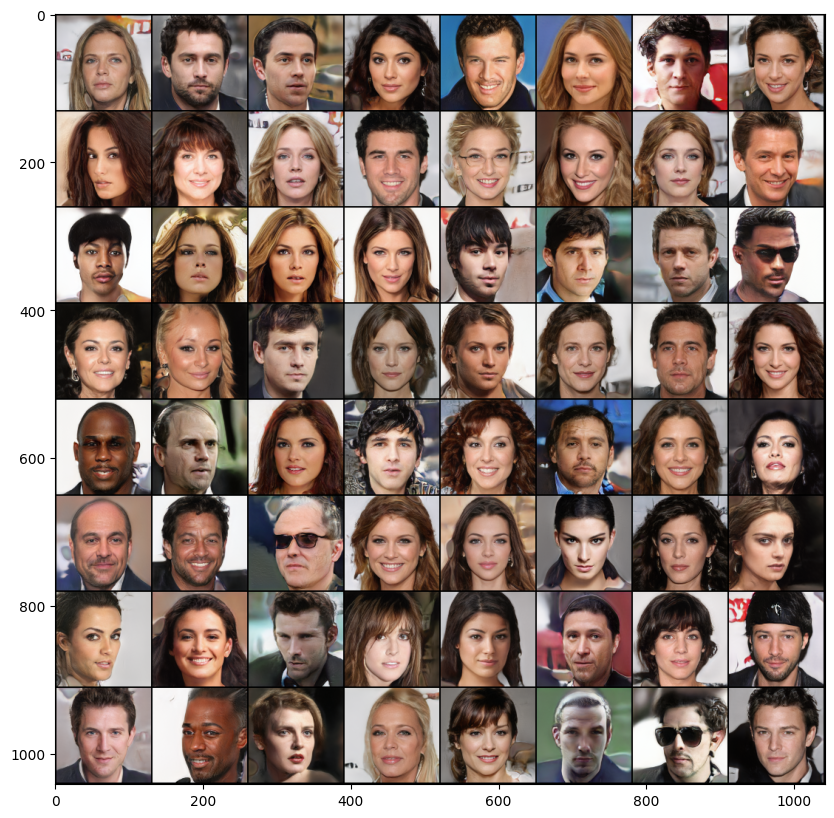

In [37]:
fixed_noise = torch.randn(64, Z_DIM).to(device)

fixed_w = ema_gen.noise_mapping(fixed_noise).unsqueeze(1).expand(-1, step+1, -1)
fixed_w = ema_gen.truncation_sampling(fixed_w)

generated_images_from_fixed_noise = ema_gen.generator_synthesis(fixed_w, step=step, alpha=alpha).detach().cpu()

img = torchvision.utils.make_grid(AdjustPixelsRange((-1., 1.), (0., 1.))(generated_images_from_fixed_noise), nrow=8).permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.imshow(img);

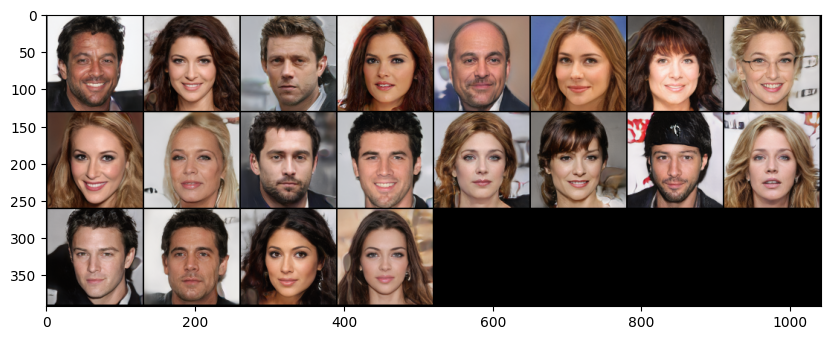

In [52]:
import random

selected_indices = [1, 3, 5, 9, 10, 11, 12, 13, 14, 22, 30, 31, 34, 40, 41, 44, 55, 59, 60, 63]
random.shuffle(selected_indices)

selected_noises = fixed_noise[selected_indices]
selected_w = fixed_w[selected_indices]

img = torchvision.utils.make_grid(AdjustPixelsRange((-1., 1.), (0., 1.))(generated_images_from_fixed_noise[selected_indices]), nrow=8).permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.imshow(img);

#### Effect of Stochastic Variation (Noise Injection)

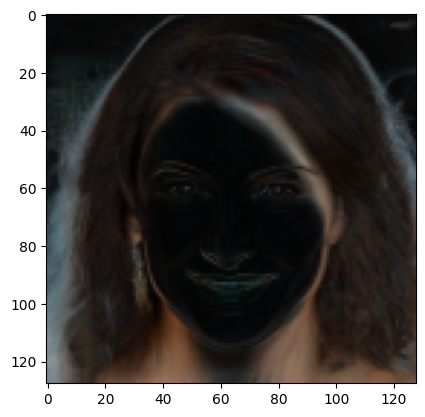

In [72]:
multiple_instances_of_the_same_w = selected_w[1].unsqueeze(0).expand(30, -1, -1)
generated_images_of_the_same_w = ema_gen.generator_synthesis(multiple_instances_of_the_same_w, step=step, alpha=alpha)

std_of_generated_images = torch.std(generated_images_of_the_same_w, dim=0).detach().cpu()

plt.imshow(std_of_generated_images.permute(1, 2, 0));

In [82]:
import cv2

video = cv2.VideoWriter("effect_of_stochastic_noise.avi", cv2.VideoWriter_fourcc(*'DIVX'), 10, (128, 128))
ff = lambda x: (((x + 1) / 2).clip(0, 1) * 255).numpy().astype(np.uint8)
for img in generated_images_of_the_same_w.detach().cpu():
    video.write(cv2.cvtColor(ff(img.permute(1, 2, 0)), cv2.COLOR_BGR2RGB))
video.release()
cv2.destroyAllWindows()

In [83]:
import moviepy.editor

def avi_to_gif(input_file, output_file):
    video = moviepy.editor.VideoFileClip(input_file)
    video.write_gif(output_file)

avi_to_gif("effect_of_stochastic_noise.avi", "effect_of_stochastic_noise.gif")

MoviePy - Building file effect_of_stochastic_noise.gif with imageio.


<img src="effect_of_stochastic_noise.gif" width=200>

#### Switching off Stochastic Variation

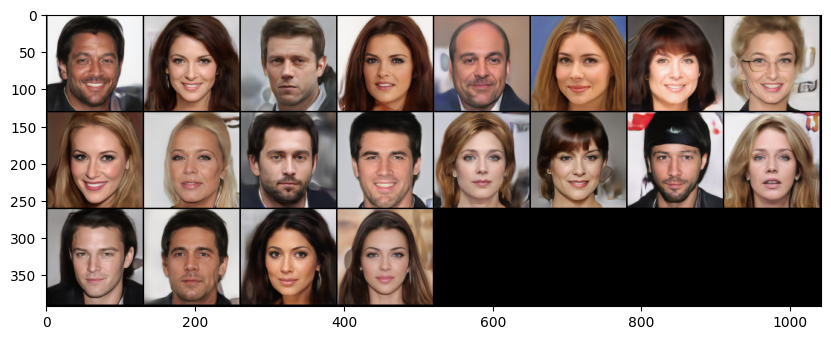

In [54]:
ema_gen.switch_noise_injection_off()

img = ema_gen.generator_synthesis(selected_w, step=step, alpha=alpha).detach().cpu()
plt.figure(figsize=(10, 10))
plt.imshow(torchvision.utils.make_grid(AdjustPixelsRange((-1., 1.), (0., 1.))(img), nrow=8).permute(1, 2, 0));

#### Interpolation

In [66]:
result_w = []
cnt = 30
percentage = torch.linspace(0, 1, cnt).view(cnt, 1).to(selected_noises[0].device)
for i in range(len(selected_noises)):
    j = i+1 if i < len(selected_noises)-1 else 0

    intermediate_w = (selected_w[i][0] * (1 - percentage)) + (selected_w[j][0] * percentage)
    intermediate_w = intermediate_w.unsqueeze(1).expand(-1, step+1, -1)

    intermediate_images_w = ema_gen.generator_synthesis(intermediate_w, step=step, alpha=alpha).detach().cpu().permute(0, 2, 3, 1)

    result_w.extend([*intermediate_images_w])

In [68]:
import cv2

video = cv2.VideoWriter("output_w.avi", cv2.VideoWriter_fourcc(*'DIVX'), 20, (128, 128))
ff = lambda x: (((x + 1) / 2).clip(0, 1) * 255).numpy().astype(np.uint8)
for img in result_w:
    video.write(cv2.cvtColor(ff(img), cv2.COLOR_BGR2RGB))
video.release()
cv2.destroyAllWindows()

In [69]:
avi_to_gif("output_w.avi", "output_w.gif")

MoviePy - Building file output_w.gif with imageio.


<img src="output_w.gif" width=200>

### Style Transfer

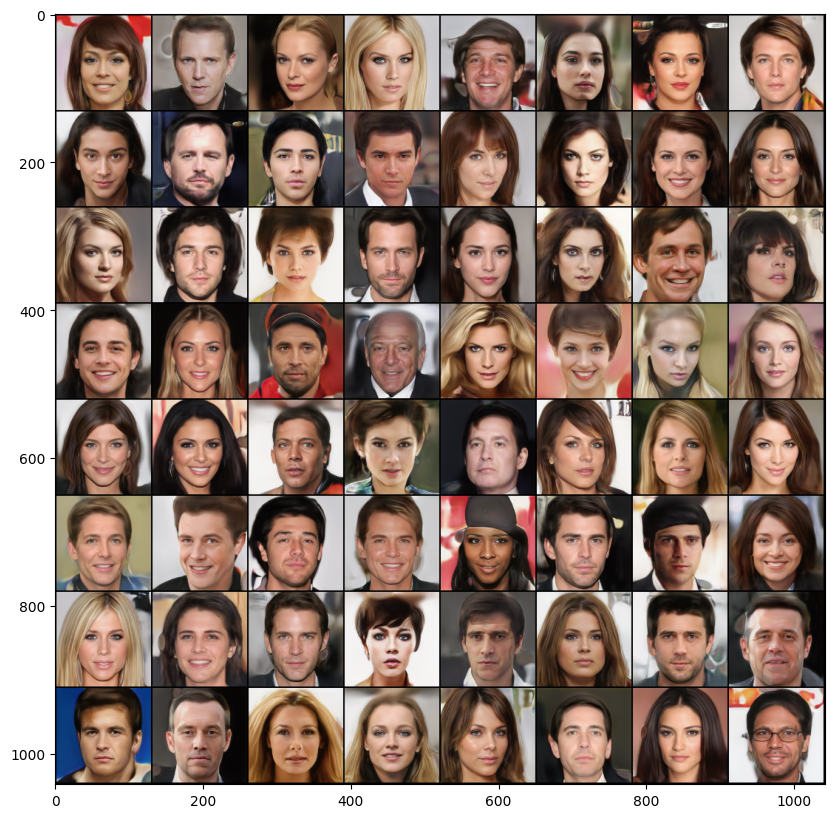

In [44]:
fixed_noise = torch.randn(64, Z_DIM).to(device)

fixed_w = ema_gen.noise_mapping(fixed_noise).unsqueeze(1).expand(-1, step+1, -1)
fixed_w = ema_gen.truncation_sampling(fixed_w)

generated_images_from_fixed_noise = ema_gen.generator_synthesis(fixed_w, step=step, alpha=alpha).detach().cpu()

img = torchvision.utils.make_grid(AdjustPixelsRange((-1., 1.), (0., 1.))(generated_images_from_fixed_noise), nrow=8).permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.imshow(img);

#### Source B

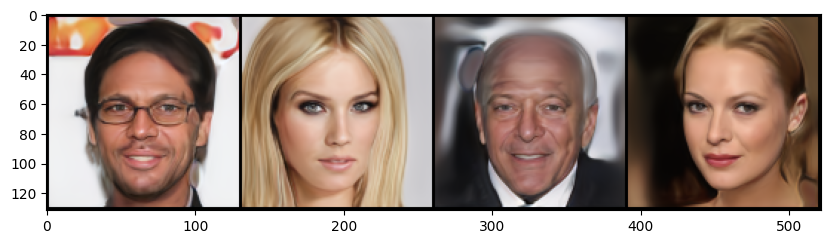

In [47]:
source_B_indices = [63, 3, 27, 2]

source_B_noises = fixed_noise[source_B_indices]
source_B_w = fixed_w[source_B_indices]

source_B_images = generated_images_from_fixed_noise[source_B_indices]

img = torchvision.utils.make_grid(AdjustPixelsRange((-1., 1.), (0., 1.))(source_B_images), nrow=8).permute(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.imshow(img);

#### Source A

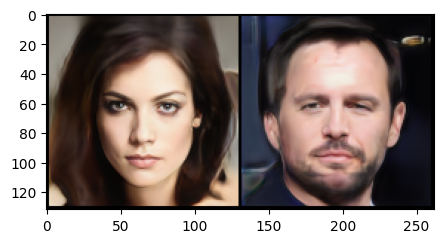

In [49]:
source_A_indices = [13, 9]

source_A_noises = fixed_noise[source_A_indices]
source_A_w = fixed_w[source_A_indices]

source_A_images = generated_images_from_fixed_noise[source_A_indices]

img = torchvision.utils.make_grid(AdjustPixelsRange((-1., 1.), (0., 1.))(source_A_images), nrow=8).permute(1, 2, 0)
plt.figure(figsize=(5, 5))
plt.imshow(img);

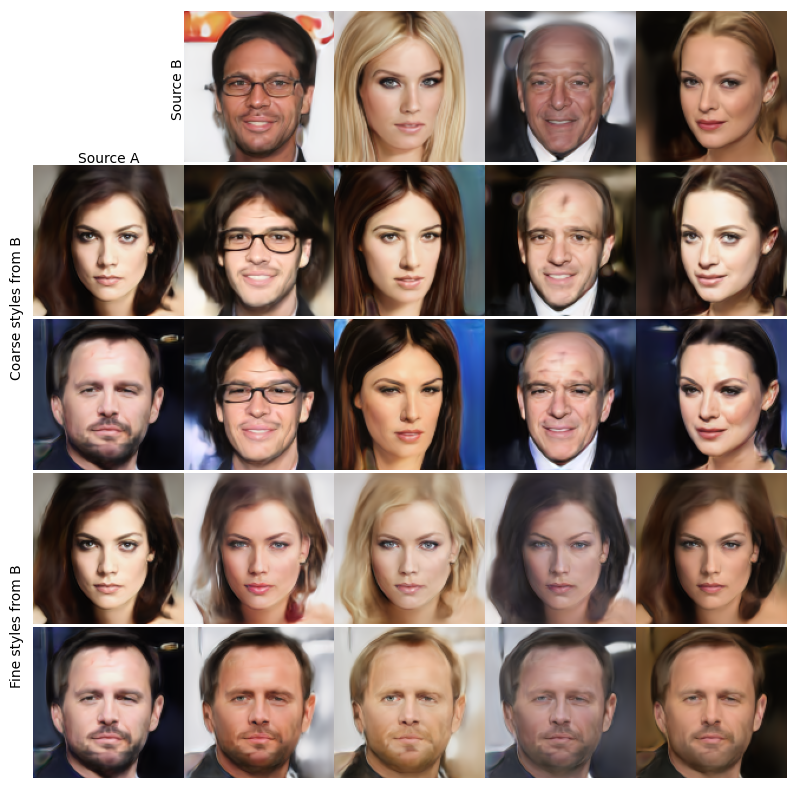

In [50]:
cut_off_coarse = 2
cut_off_fine = 3

nrows, ncols = 5, 5
fig, axs = plt.subplots(nrows, ncols, figsize=(8, 8))

for i in range(nrows):
    for j in range(ncols):
        axs[i][j].axis('off')

for i in range(1, 5):
    axs[0][i].imshow(AdjustPixelsRange((-1., 1.), (0., 1.))(source_B_images[i-1].permute(1, 2, 0)))

# Coarse style transfer
for i in range(len(source_A_indices)):
    axs[i+1][0].imshow(AdjustPixelsRange((-1., 1.), (0., 1.))(source_A_images[i].permute(1, 2, 0)))
    for j in range(len(source_B_indices)):
        combined_w = torch.cat((source_B_w[j][:cut_off_coarse], source_A_w[i][cut_off_coarse:]), dim=0).unsqueeze(0)
        generated_img = ema_gen.generator_synthesis(combined_w, step=step, alpha=alpha).detach().cpu()
        axs[i+1][j+1].imshow(AdjustPixelsRange((-1., 1.), (0., 1.))(generated_img[0].permute(1, 2, 0)))

# Fine style transfer
for i in range(len(source_A_indices)):
    axs[i+3][0].imshow(AdjustPixelsRange((-1., 1.), (0., 1.))(source_A_images[i].permute(1, 2, 0)))
    for j in range(len(source_B_indices)):
        combined_w = torch.cat((source_A_w[i][:cut_off_fine], source_B_w[j][cut_off_fine:]), dim=0).unsqueeze(0)
        generated_img = ema_gen.generator_synthesis(combined_w, step=step, alpha=alpha).detach().cpu()
        axs[i+3][j+1].imshow(AdjustPixelsRange((-1., 1.), (0., 1.))(generated_img[0].permute(1, 2, 0)))

axs[1][0].text(0.3, 1.02, 'Source A', transform=axs[1][0].transAxes)
axs[0][1].text(-0.08, 0.3, 'Source B', rotation=90, transform=axs[0][1].transAxes)

axs[1][0].text(-0.15, -0.4, 'Coarse styles from B', rotation=90, transform=axs[1][0].transAxes)
axs[3][0].text(-0.15, -0.4, 'Fine styles from B', rotation=90, transform=axs[3][0].transAxes)

fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
